In [1]:
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.datasets import make_classification
from tqdm import tqdm
from scipy.stats import norm
import pandas as pd

In [2]:
def fitModel(model,optimizer,criterion,epochs,x,target, a=False):
    for epoch in range(epochs):
            # Forward pass: Compute predicted y by passing x to the model
        if a is not None:
            y_pred,_ = model(x)
        else:
            y_pred,_ = model(x,a)
        # Compute and print loss
        loss = criterion(y_pred, target)
        #print(epoch, loss.data[0])
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
    return model

In [3]:
def softmax(w, t = 1.0):
    e = np.exp(w / t)
    return e/np.sum(e,1)[:,np.newaxis]

In [4]:
class Net(nn.Module):
    def __init__(self,d,q):
        super(Net, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(d, q),
        )

    def forward(self,x):
        x = torch.tanh(self.fc(x))
        x1 = F.softmax(x, dim=1)
        return x1,x

In [5]:
class TRAM(nn.Module):
    def __init__(self, d, d1, d2, q):
        super(TRAM, self).__init__()
        self.fc_x = nn.Linear(d1, d)
        self.fc_a = nn.Linear(d2, d)
        # No PI head
        self.head1 = nn.Sequential(
            nn.Linear(d, q),
            nn.Softmax(dim=1)
        )
        # PI head
        self.head2 = nn.Sequential(
            nn.Linear(d, q)
        )

    def forward(self, x, a=None):
        x = self.fc_x(x)
        # stop gradient for no PI head using .detach()
        y_pred1 = self.head1(x.detach())

        if a is not None:
            a = self.fc_a(a)
            y_pred2 = self.head2(a)
            return y_pred1, y_pred2

        return y_pred1, None

In [6]:
def do_exp(x_tr,xs_tr,y_tr,x_te,xs_te,y_te):
    t = 1
    l = 1
    l_r=0.01
    epochs=1000
    criterion = torch.nn.CrossEntropyLoss()

    """
    Training of privileged model
    """
    xs_tr = Variable(torch.from_numpy(xs_tr)).type(torch.FloatTensor)
    y_tr = Variable(torch.from_numpy(y_tr*1.0)).type(torch.FloatTensor)
    mlp_priv = Net(xs_tr.shape[1], y_tr.shape[1])
    optimizer = optim.SGD(mlp_priv.parameters(),lr=l_r)
    mlp_priv=fitModel(mlp_priv,optimizer,criterion,epochs,xs_tr,y_tr)
    xs_te = Variable(torch.from_numpy(xs_te)).type(torch.FloatTensor)
    _,soften=mlp_priv(xs_tr)
    output,_=mlp_priv(xs_te)
    pred = torch.argmax(output,dim=1)
    pred=pred.numpy()
    res_priv=np.mean(pred==np.argmax(y_te,1))
    """
    Training of regular MLP
    """
    x_tr = Variable(torch.from_numpy(x_tr)).type(torch.FloatTensor)
    mlp_reg = Net(x_tr.shape[1], y_tr.shape[1])
    optimizer = optim.Adam(mlp_reg.parameters(),lr=l_r)
    mlp_reg=fitModel(mlp_reg,optimizer,criterion,epochs,x_tr,y_tr)
    x_te = Variable(torch.from_numpy(x_te)).type(torch.FloatTensor)
    output,_=mlp_reg(x_te)
    pred = torch.argmax(output,dim=1)
    pred=pred.numpy()
    res_reg=np.mean(pred==np.argmax(y_te,1))

    softened=soften.detach()
    softened=softened.numpy()
    p_tr=softmax(softened,t)
    p_tr=Variable(torch.from_numpy(p_tr)).type(torch.FloatTensor)

    ### freezing layers
    for param in mlp_priv.parameters():
        param.requires_grad =False
    """
    LUPI Combination of two model
    """
    mlp_dist = Net(x_tr.shape[1], y_tr.shape[1])
    optimizer = optim.Adam(mlp_dist.parameters(),lr=l_r)
    criterion = torch.nn.CrossEntropyLoss()
    # Training loop
    for epoch in range(epochs):
        # Forward pass: Compute predicted y by passing x to the model
        y_pred,_ = mlp_dist(x_tr)
        # Compute and print loss
        loss1 = (1-l)*criterion(y_pred, y_tr)
        loss2 = t*t*l*criterion(y_pred, p_tr)
        loss = loss1 + loss2
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
    output,_=mlp_dist(x_te)
    pred = torch.argmax(output,dim=1)
    pred=pred.numpy()
    res_dis=np.mean(pred==np.argmax(y_te,1))
    """
    Training TRAM.
    """
    mlp_tram = TRAM(16, x_tr.shape[1], xs_tr.shape[1], y_tr.shape[1])
    optimizer = optim.Adam(mlp_tram.parameters(),lr=l_r)
    mlp_tram=fitModel(mlp_tram,optimizer,criterion,epochs,x_tr,y_tr,xs_tr)
    output,_=mlp_tram(x_te)
    pred = torch.argmax(output,dim=1)
    pred=pred.numpy()
    res_tram=np.mean(pred==np.argmax(y_te,1))

    return np.array([res_priv, res_reg, res_dis, res_tram])

In [7]:
# experiment hyper-parameters
n_reps = 10
results = {}
num_samples = [50, 100, 200, 500, 1000, 2000, 5000, 10000]
strengths = range(1, 16)
heatmap_data = {
    "Privileged": np.zeros((len(num_samples), len(strengths))),
    "Generalized Distillation": np.zeros((len(num_samples), len(strengths))),
    "No PI": np.zeros((len(num_samples), len(strengths))),
    "TRAM": np.zeros((len(num_samples), len(strengths)))
               }

## Scaling the sample size
print("Training_size\tPrivileged\tNo PI\t\tGeneralised Distillation\tTRAM")

for i, n_tr in enumerate(num_samples):
    np.random.seed(0)
    xx, y = make_classification(n_samples=n_tr+10000, 
                                n_features=20, n_informative=20, n_redundant=0, n_repeated=0, 
                                n_classes=3, flip_y=0.0, class_sep=2., random_state=42
    )
    y = pd.get_dummies(y).values.astype(np.float32)
    for j, strength in enumerate(strengths):
        R = np.zeros((n_reps,4))
        for rep in tqdm(range(n_reps)):
            xs_tr, x_tr, y_tr = xx[:n_tr, :], xx[:n_tr, :strength], y[:n_tr]
            xs_te, x_te, y_te = xx[n_tr:, :], xx[n_tr:, :strength], y[n_tr:]
            R[rep,:] += do_exp(x_tr,xs_tr,y_tr,x_te,xs_te,y_te)
        means = R.mean(axis=0).round(2)
        stds  = R.std(axis=0).round(2)
        print(f"{n_tr}\t\t{means[0]}(+/-{stds[0]})\t{means[1]}(+/-{stds[1]})\t{means[2]}(+/-{stds[2]})\t\t\t{means[3]}(+/-{stds[3]})\t")
        #print(f"{n_tr}\t\t{means[0]}(+/-{stds[0]})\t{means[1]}(+/-{stds[1]})\t{means[2]}(+/-{stds[2]})")

        heatmap_data["Privileged"][i, j] = means[0]
        heatmap_data["No PI"][i, j] = means[1]
        heatmap_data["Generalized Distillation"][i, j] = means[2]
        heatmap_data["TRAM"][i, j] = means[3]

        results[i] = R

Training_size	Privileged	No PI		Generalised Distillation	TRAM


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:28<00:00,  2.84s/it]


50		0.75(+/-0.03)	0.42(+/-0.04)	0.43(+/-0.0)			0.43(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.54s/it]


50		0.76(+/-0.04)	0.52(+/-0.0)	0.52(+/-0.02)			0.52(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:26<00:00,  2.60s/it]


50		0.77(+/-0.02)	0.52(+/-0.03)	0.53(+/-0.01)			0.53(+/-0.01)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:28<00:00,  2.81s/it]


50		0.76(+/-0.02)	0.54(+/-0.01)	0.54(+/-0.01)			0.53(+/-0.01)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.74s/it]


50		0.77(+/-0.03)	0.54(+/-0.01)	0.53(+/-0.01)			0.53(+/-0.01)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.59s/it]


50		0.77(+/-0.03)	0.55(+/-0.01)	0.53(+/-0.01)			0.54(+/-0.04)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.58s/it]


50		0.76(+/-0.03)	0.57(+/-0.02)	0.56(+/-0.03)			0.56(+/-0.03)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:26<00:00,  2.62s/it]


50		0.77(+/-0.02)	0.56(+/-0.02)	0.56(+/-0.03)			0.59(+/-0.02)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.74s/it]


50		0.76(+/-0.03)	0.57(+/-0.01)	0.57(+/-0.02)			0.6(+/-0.03)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:28<00:00,  2.87s/it]


50		0.77(+/-0.03)	0.6(+/-0.01)	0.58(+/-0.02)			0.6(+/-0.04)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:26<00:00,  2.66s/it]


50		0.77(+/-0.04)	0.65(+/-0.02)	0.63(+/-0.03)			0.63(+/-0.04)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.79s/it]


50		0.78(+/-0.02)	0.66(+/-0.02)	0.64(+/-0.03)			0.63(+/-0.05)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:28<00:00,  2.81s/it]


50		0.77(+/-0.03)	0.66(+/-0.01)	0.63(+/-0.03)			0.62(+/-0.04)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:34<00:00,  3.46s/it]


50		0.79(+/-0.02)	0.7(+/-0.02)	0.68(+/-0.02)			0.63(+/-0.03)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.57s/it]


50		0.77(+/-0.03)	0.73(+/-0.02)	0.72(+/-0.02)			0.64(+/-0.06)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:29<00:00,  2.98s/it]


100		0.86(+/-0.03)	0.44(+/-0.0)	0.44(+/-0.0)			0.45(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:30<00:00,  3.09s/it]


100		0.87(+/-0.01)	0.51(+/-0.03)	0.52(+/-0.01)			0.53(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:34<00:00,  3.47s/it]


100		0.86(+/-0.02)	0.54(+/-0.01)	0.54(+/-0.01)			0.54(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:28<00:00,  2.81s/it]


100		0.87(+/-0.02)	0.64(+/-0.02)	0.64(+/-0.01)			0.64(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:26<00:00,  2.69s/it]


100		0.82(+/-0.05)	0.65(+/-0.01)	0.64(+/-0.02)			0.66(+/-0.02)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:26<00:00,  2.63s/it]


100		0.85(+/-0.03)	0.72(+/-0.01)	0.69(+/-0.03)			0.73(+/-0.01)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.71s/it]


100		0.86(+/-0.01)	0.69(+/-0.04)	0.7(+/-0.01)			0.7(+/-0.01)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.77s/it]


100		0.86(+/-0.03)	0.7(+/-0.01)	0.7(+/-0.03)			0.69(+/-0.02)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.56s/it]


100		0.86(+/-0.02)	0.69(+/-0.02)	0.69(+/-0.02)			0.68(+/-0.03)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.49s/it]


100		0.85(+/-0.02)	0.68(+/-0.02)	0.68(+/-0.04)			0.66(+/-0.04)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.52s/it]


100		0.86(+/-0.02)	0.67(+/-0.04)	0.69(+/-0.03)			0.67(+/-0.03)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:26<00:00,  2.62s/it]


100		0.84(+/-0.04)	0.7(+/-0.02)	0.7(+/-0.02)			0.69(+/-0.02)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.74s/it]


100		0.87(+/-0.03)	0.73(+/-0.02)	0.73(+/-0.02)			0.68(+/-0.03)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:26<00:00,  2.61s/it]


100		0.86(+/-0.03)	0.72(+/-0.02)	0.73(+/-0.02)			0.71(+/-0.04)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.48s/it]


100		0.86(+/-0.02)	0.73(+/-0.01)	0.73(+/-0.02)			0.69(+/-0.03)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.54s/it]


200		0.86(+/-0.01)	0.4(+/-0.04)	0.42(+/-0.0)			0.44(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:26<00:00,  2.65s/it]


200		0.86(+/-0.01)	0.57(+/-0.01)	0.57(+/-0.01)			0.54(+/-0.01)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:28<00:00,  2.82s/it]


200		0.86(+/-0.01)	0.57(+/-0.0)	0.56(+/-0.01)			0.57(+/-0.01)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.57s/it]


200		0.86(+/-0.01)	0.6(+/-0.01)	0.59(+/-0.01)			0.6(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.54s/it]


200		0.86(+/-0.01)	0.59(+/-0.0)	0.59(+/-0.0)			0.61(+/-0.01)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.57s/it]


200		0.86(+/-0.01)	0.62(+/-0.01)	0.62(+/-0.02)			0.63(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.71s/it]


200		0.86(+/-0.01)	0.67(+/-0.01)	0.67(+/-0.01)			0.66(+/-0.01)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:28<00:00,  2.85s/it]


200		0.86(+/-0.02)	0.69(+/-0.0)	0.69(+/-0.01)			0.68(+/-0.01)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.53s/it]


200		0.86(+/-0.01)	0.7(+/-0.0)	0.69(+/-0.01)			0.69(+/-0.01)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:26<00:00,  2.60s/it]


200		0.86(+/-0.01)	0.7(+/-0.01)	0.71(+/-0.02)			0.71(+/-0.01)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.53s/it]


200		0.86(+/-0.01)	0.73(+/-0.0)	0.72(+/-0.0)			0.72(+/-0.02)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:26<00:00,  2.65s/it]


200		0.85(+/-0.02)	0.73(+/-0.0)	0.72(+/-0.02)			0.7(+/-0.03)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.79s/it]


200		0.86(+/-0.01)	0.76(+/-0.01)	0.76(+/-0.01)			0.73(+/-0.03)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:26<00:00,  2.62s/it]


200		0.86(+/-0.01)	0.76(+/-0.02)	0.75(+/-0.01)			0.72(+/-0.01)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.56s/it]


200		0.86(+/-0.01)	0.8(+/-0.01)	0.8(+/-0.01)			0.76(+/-0.02)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:26<00:00,  2.65s/it]


500		0.87(+/-0.01)	0.44(+/-0.0)	0.43(+/-0.01)			0.43(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.71s/it]


500		0.87(+/-0.01)	0.52(+/-0.0)	0.51(+/-0.0)			0.52(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:29<00:00,  2.92s/it]


500		0.87(+/-0.0)	0.52(+/-0.03)	0.53(+/-0.02)			0.54(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.76s/it]


500		0.87(+/-0.0)	0.57(+/-0.03)	0.56(+/-0.04)			0.58(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:26<00:00,  2.68s/it]


500		0.88(+/-0.0)	0.59(+/-0.0)	0.58(+/-0.03)			0.61(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.71s/it]


500		0.88(+/-0.0)	0.6(+/-0.02)	0.61(+/-0.0)			0.62(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.74s/it]


500		0.87(+/-0.02)	0.63(+/-0.0)	0.63(+/-0.01)			0.64(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:28<00:00,  2.88s/it]


500		0.87(+/-0.01)	0.64(+/-0.03)	0.66(+/-0.01)			0.67(+/-0.01)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:28<00:00,  2.81s/it]


500		0.87(+/-0.01)	0.65(+/-0.03)	0.67(+/-0.01)			0.66(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:26<00:00,  2.63s/it]


500		0.87(+/-0.0)	0.67(+/-0.01)	0.68(+/-0.02)			0.67(+/-0.01)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:30<00:00,  3.05s/it]


500		0.87(+/-0.0)	0.68(+/-0.01)	0.68(+/-0.01)			0.66(+/-0.02)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:31<00:00,  3.17s/it]


500		0.88(+/-0.0)	0.69(+/-0.0)	0.68(+/-0.0)			0.67(+/-0.02)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:30<00:00,  3.03s/it]


500		0.87(+/-0.01)	0.76(+/-0.0)	0.76(+/-0.01)			0.74(+/-0.02)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.79s/it]


500		0.87(+/-0.0)	0.77(+/-0.0)	0.77(+/-0.01)			0.73(+/-0.02)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.75s/it]


500		0.87(+/-0.0)	0.78(+/-0.01)	0.78(+/-0.0)			0.73(+/-0.02)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:30<00:00,  3.03s/it]


1000		0.88(+/-0.01)	0.42(+/-0.0)	0.42(+/-0.01)			0.42(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:31<00:00,  3.11s/it]


1000		0.87(+/-0.02)	0.49(+/-0.0)	0.48(+/-0.01)			0.49(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:28<00:00,  2.84s/it]


1000		0.87(+/-0.01)	0.65(+/-0.0)	0.63(+/-0.01)			0.65(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:28<00:00,  2.87s/it]


1000		0.87(+/-0.03)	0.69(+/-0.0)	0.68(+/-0.01)			0.7(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:28<00:00,  2.88s/it]


1000		0.88(+/-0.01)	0.69(+/-0.0)	0.69(+/-0.01)			0.7(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:31<00:00,  3.10s/it]


1000		0.87(+/-0.02)	0.71(+/-0.0)	0.71(+/-0.01)			0.71(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:29<00:00,  2.90s/it]


1000		0.88(+/-0.01)	0.73(+/-0.0)	0.72(+/-0.0)			0.72(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:28<00:00,  2.87s/it]


1000		0.87(+/-0.02)	0.73(+/-0.0)	0.73(+/-0.01)			0.73(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:28<00:00,  2.87s/it]


1000		0.87(+/-0.02)	0.74(+/-0.0)	0.73(+/-0.01)			0.73(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:29<00:00,  2.96s/it]


1000		0.88(+/-0.01)	0.78(+/-0.0)	0.78(+/-0.01)			0.78(+/-0.01)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:30<00:00,  3.10s/it]


1000		0.86(+/-0.03)	0.79(+/-0.0)	0.78(+/-0.01)			0.79(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:30<00:00,  3.00s/it]


1000		0.87(+/-0.02)	0.8(+/-0.0)	0.78(+/-0.01)			0.78(+/-0.01)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:29<00:00,  2.92s/it]


1000		0.88(+/-0.01)	0.8(+/-0.0)	0.79(+/-0.0)			0.78(+/-0.01)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:30<00:00,  3.05s/it]


1000		0.87(+/-0.02)	0.84(+/-0.0)	0.83(+/-0.01)			0.8(+/-0.01)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:31<00:00,  3.15s/it]


1000		0.86(+/-0.03)	0.86(+/-0.0)	0.84(+/-0.02)			0.83(+/-0.01)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:34<00:00,  3.41s/it]


2000		0.88(+/-0.01)	0.42(+/-0.0)	0.42(+/-0.0)			0.41(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:33<00:00,  3.34s/it]


2000		0.87(+/-0.02)	0.46(+/-0.0)	0.46(+/-0.01)			0.46(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:34<00:00,  3.41s/it]


2000		0.87(+/-0.03)	0.55(+/-0.0)	0.55(+/-0.0)			0.55(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:33<00:00,  3.31s/it]


2000		0.88(+/-0.01)	0.66(+/-0.0)	0.65(+/-0.01)			0.66(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:33<00:00,  3.30s/it]


2000		0.88(+/-0.01)	0.66(+/-0.0)	0.66(+/-0.0)			0.66(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:34<00:00,  3.42s/it]


2000		0.88(+/-0.01)	0.71(+/-0.0)	0.71(+/-0.0)			0.72(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:34<00:00,  3.47s/it]


2000		0.88(+/-0.01)	0.73(+/-0.0)	0.73(+/-0.0)			0.74(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:32<00:00,  3.25s/it]


2000		0.88(+/-0.01)	0.73(+/-0.0)	0.73(+/-0.0)			0.74(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:32<00:00,  3.25s/it]


2000		0.86(+/-0.02)	0.73(+/-0.0)	0.73(+/-0.01)			0.74(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:35<00:00,  3.56s/it]


2000		0.88(+/-0.01)	0.75(+/-0.0)	0.75(+/-0.0)			0.75(+/-0.01)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:33<00:00,  3.32s/it]


2000		0.88(+/-0.01)	0.75(+/-0.0)	0.75(+/-0.0)			0.76(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:32<00:00,  3.29s/it]


2000		0.88(+/-0.01)	0.78(+/-0.0)	0.77(+/-0.0)			0.76(+/-0.01)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:33<00:00,  3.37s/it]


2000		0.87(+/-0.02)	0.8(+/-0.0)	0.79(+/-0.01)			0.78(+/-0.02)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:35<00:00,  3.59s/it]


2000		0.87(+/-0.03)	0.8(+/-0.0)	0.79(+/-0.01)			0.77(+/-0.02)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:32<00:00,  3.30s/it]


2000		0.87(+/-0.01)	0.83(+/-0.0)	0.83(+/-0.0)			0.79(+/-0.03)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:42<00:00,  4.22s/it]


5000		0.88(+/-0.02)	0.52(+/-0.0)	0.52(+/-0.0)			0.52(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:44<00:00,  4.43s/it]


5000		0.89(+/-0.01)	0.52(+/-0.0)	0.52(+/-0.0)			0.52(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:42<00:00,  4.24s/it]


5000		0.89(+/-0.0)	0.61(+/-0.0)	0.6(+/-0.0)			0.61(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:44<00:00,  4.46s/it]


5000		0.89(+/-0.01)	0.65(+/-0.0)	0.64(+/-0.01)			0.65(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:43<00:00,  4.39s/it]


5000		0.89(+/-0.01)	0.66(+/-0.0)	0.65(+/-0.0)			0.66(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:43<00:00,  4.31s/it]


5000		0.89(+/-0.01)	0.67(+/-0.0)	0.66(+/-0.0)			0.67(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:46<00:00,  4.60s/it]


5000		0.89(+/-0.01)	0.69(+/-0.0)	0.68(+/-0.01)			0.69(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:42<00:00,  4.30s/it]


5000		0.89(+/-0.01)	0.7(+/-0.0)	0.69(+/-0.01)			0.7(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:43<00:00,  4.37s/it]


5000		0.89(+/-0.01)	0.74(+/-0.0)	0.73(+/-0.01)			0.74(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:44<00:00,  4.47s/it]


5000		0.89(+/-0.0)	0.79(+/-0.0)	0.78(+/-0.0)			0.79(+/-0.01)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:42<00:00,  4.27s/it]


5000		0.89(+/-0.01)	0.81(+/-0.0)	0.8(+/-0.0)			0.8(+/-0.01)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:44<00:00,  4.44s/it]


5000		0.89(+/-0.01)	0.81(+/-0.0)	0.8(+/-0.01)			0.8(+/-0.01)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:44<00:00,  4.46s/it]


5000		0.88(+/-0.02)	0.83(+/-0.0)	0.81(+/-0.02)			0.81(+/-0.01)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:43<00:00,  4.34s/it]


5000		0.89(+/-0.01)	0.83(+/-0.0)	0.82(+/-0.01)			0.79(+/-0.02)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:45<00:00,  4.50s/it]


5000		0.89(+/-0.02)	0.83(+/-0.0)	0.82(+/-0.01)			0.8(+/-0.02)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:59<00:00,  5.99s/it]


10000		0.86(+/-0.02)	0.33(+/-0.0)	0.34(+/-0.0)			0.33(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:59<00:00,  6.00s/it]


10000		0.87(+/-0.01)	0.33(+/-0.0)	0.34(+/-0.0)			0.33(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:59<00:00,  5.93s/it]


10000		0.86(+/-0.01)	0.43(+/-0.0)	0.43(+/-0.0)			0.44(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:01<00:00,  6.12s/it]


10000		0.86(+/-0.01)	0.55(+/-0.0)	0.55(+/-0.0)			0.55(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:58<00:00,  5.88s/it]


10000		0.86(+/-0.01)	0.58(+/-0.0)	0.56(+/-0.01)			0.58(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:59<00:00,  5.96s/it]


10000		0.86(+/-0.01)	0.64(+/-0.0)	0.64(+/-0.0)			0.64(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:00<00:00,  6.05s/it]


10000		0.87(+/-0.01)	0.64(+/-0.0)	0.64(+/-0.0)			0.65(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:04<00:00,  6.40s/it]


10000		0.86(+/-0.02)	0.65(+/-0.01)	0.65(+/-0.0)			0.66(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:03<00:00,  6.38s/it]


10000		0.87(+/-0.01)	0.67(+/-0.01)	0.67(+/-0.0)			0.69(+/-0.01)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:04<00:00,  6.46s/it]


10000		0.86(+/-0.02)	0.74(+/-0.0)	0.73(+/-0.01)			0.73(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:05<00:00,  6.57s/it]


10000		0.86(+/-0.02)	0.73(+/-0.0)	0.73(+/-0.0)			0.74(+/-0.0)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:00<00:00,  6.05s/it]


10000		0.87(+/-0.0)	0.74(+/-0.0)	0.74(+/-0.0)			0.75(+/-0.01)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:05<00:00,  6.52s/it]


10000		0.86(+/-0.0)	0.75(+/-0.0)	0.74(+/-0.01)			0.76(+/-0.01)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:59<00:00,  5.97s/it]


10000		0.85(+/-0.02)	0.79(+/-0.0)	0.78(+/-0.01)			0.76(+/-0.02)	


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:02<00:00,  6.21s/it]

10000		0.86(+/-0.01)	0.81(+/-0.0)	0.8(+/-0.01)			0.77(+/-0.02)	


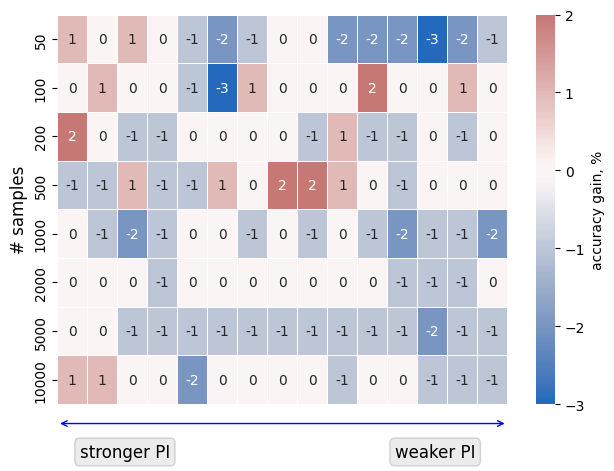

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

dupi_uplift = (heatmap_data['Generalized Distillation'] - heatmap_data['No PI']) * 100
y_axis_labels = num_samples
ax = sns.heatmap(dupi_uplift, linewidth=0.5, cmap ="vlag", center=0, annot=True, xticklabels=False, 
                 yticklabels=y_axis_labels, cbar_kws={'label': 'accuracy gain, %'})
ax.annotate('', xy=(0, -0.05), xycoords='axes fraction', xytext=(1, -0.05), 
            arrowprops=dict(arrowstyle="<->", color='b'))
props = dict(boxstyle='round', facecolor='grey', alpha=0.15)  # bbox features
ax.text(0.05, -0.1, 'stronger PI', transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)
ax.text(0.75, -0.1, 'weaker PI', transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)
plt.ylabel('# samples', fontsize = 12) # x-axis label with fontsize 15
plt.tight_layout()
plt.savefig('pics/dupi_heatmap.png', bbox_inches='tight')
plt.show()

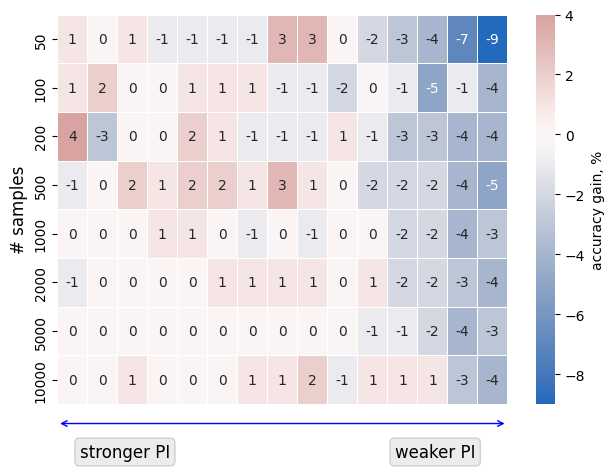

In [9]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
tram_uplift = (heatmap_data['TRAM'] - heatmap_data['No PI']) * 100

y_axis_labels = num_samples
ax = sns.heatmap(tram_uplift, linewidth=0.5, cmap ="vlag", center=0, annot=True, xticklabels=False, 
                 yticklabels=y_axis_labels, cbar_kws={'label': 'accuracy gain, %'})
ax.annotate('', xy=(0, -0.05), xycoords='axes fraction', xytext=(1, -0.05), 
            arrowprops=dict(arrowstyle="<->", color='b'))
props = dict(boxstyle='round', facecolor='grey', alpha=0.15)  # bbox features
ax.text(0.05, -0.1, 'stronger PI', transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)
ax.text(0.75, -0.1, 'weaker PI', transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)
plt.ylabel('# samples', fontsize = 12) # x-axis label with fontsize 15
plt.tight_layout()
plt.savefig('pics/tram_heatmap.png', bbox_inches='tight')
plt.show()